In [113]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import os
plt.rcParams["figure.figsize"]=14,5
import holidays
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings("ignore")
import sys


# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# import tensorflow as tf
import seaborn as sns
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from logger import logger
# from tabulate import tabulate
import requests
# from sklearn.cluster import DBSCAN
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# import joblib
# import tensorflow as tf
# logger.info(f"tf version:{tf.__version__}")
# from tensorflow import keras
# from tensorflow.keras import layers                         # type: ignore
# from tensorflow.keras.models import Sequential              # type: ignore
# from tensorflow.keras.layers import LSTM, Dense, Dropout    # type: ignore
# from tensorflow.keras import regularizers                   # type: ignore
# from sklearn.inspection import permutation_importance
# np.set_printoptions(precision=3, suppress=True)
# import pickle
# from xgboost import XGBRegressor
# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
# from math import sqrt


In [97]:
df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
df = df.copy()

df.drop("sensor", axis=1, inplace=True)
print(f"df rows: {len(df)}")
print(f"Duplicated rows: {df.duplicated().sum()}")
df.set_index("creation_time", drop=True, inplace=True)
df = df.loc[df.index.year>2022]
df = df.loc[~ ((df.index.year==2024) & (df.index.month>5))]

print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
df = df.drop_duplicates()
df = df[df['R_Voltage'] != 0]
# df = df.loc[~df['R_Voltage'] == 0]
print(f"Duplicated index: {df.index.duplicated().sum()}")
print(f"null_values : \n{df.isna().sum()}")
print(f"df rows after basic checks: {len(df)}")
df

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 38
Duplicated index: 0
null_values : 
R_Voltage    0
Y_Voltage    0
B_Voltage    0
R_Current    0
Y_Current    0
B_Current    0
KWh          0
dtype: int64
df rows after basic checks: 24777


,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
creation_time,,,,,,,
2023-01-01 00:00:00,6392.0,6352.0,6397.0,5.02,5.68,5.09,48.3
2023-01-01 00:30:00,6418.0,6379.0,6426.0,4.39,5.14,4.82,42.7
2023-01-01 01:00:00,6418.0,6380.0,6428.0,4.81,3.78,5.11,40.4
2023-01-01 01:30:00,6436.0,6399.0,6449.0,3.49,3.06,4.05,29.6
2023-01-01 02:00:00,6447.0,6411.0,6460.0,3.69,3.26,4.27,32.1
...,...,...,...,...,...,...,...
2024-05-31 21:30:00,6266.0,6296.0,6294.0,24.90,24.04,25.35,228.3
2024-05-31 22:00:00,6228.0,6256.0,6256.0,26.73,25.31,24.82,235.3
2024-05-31 22:30:00,6215.0,6248.0,6241.0,27.74,27.69,26.61,252.0


In [100]:
(365+31+29+31+30+31)*48
24816-24777

39

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25736 entries, 2022-12-12 00:30:00 to 2024-05-31 23:30:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   R_Voltage  25736 non-null  float64
 1   Y_Voltage  25736 non-null  float64
 2   B_Voltage  25736 non-null  float64
 3   R_Current  25736 non-null  float64
 4   Y_Current  25736 non-null  float64
 5   B_Current  25736 non-null  float64
 6   KWh        25736 non-null  float64
dtypes: float64(7)
memory usage: 2.6 MB


In [87]:
df.describe()

,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
count,25736.000000,25736.000000,25736.000000,25736.000000,25736.000000,25736.000000,25736.000000
mean,6211.833968,6216.884248,6199.729057,8.816750,8.726186,9.536311,80.624137
std,158.386410,162.171874,152.897377,5.199643,4.542819,4.669903,43.910031
min,5427.000000,383.000000,5608.000000,1.970000,1.700000,1.920000,0.700000
25%,6104.000000,6111.000000,6094.000000,4.810000,5.220000,5.900000,47.200000
50%,6207.500000,6216.000000,6198.000000,7.500000,7.730000,8.570000,70.500000
75%,6321.000000,6328.000000,6306.000000,11.370000,11.080000,12.070000,102.700000
max,6923.000000,6911.000000,6848.000000,36.280000,33.320000,36.460000,314.000000


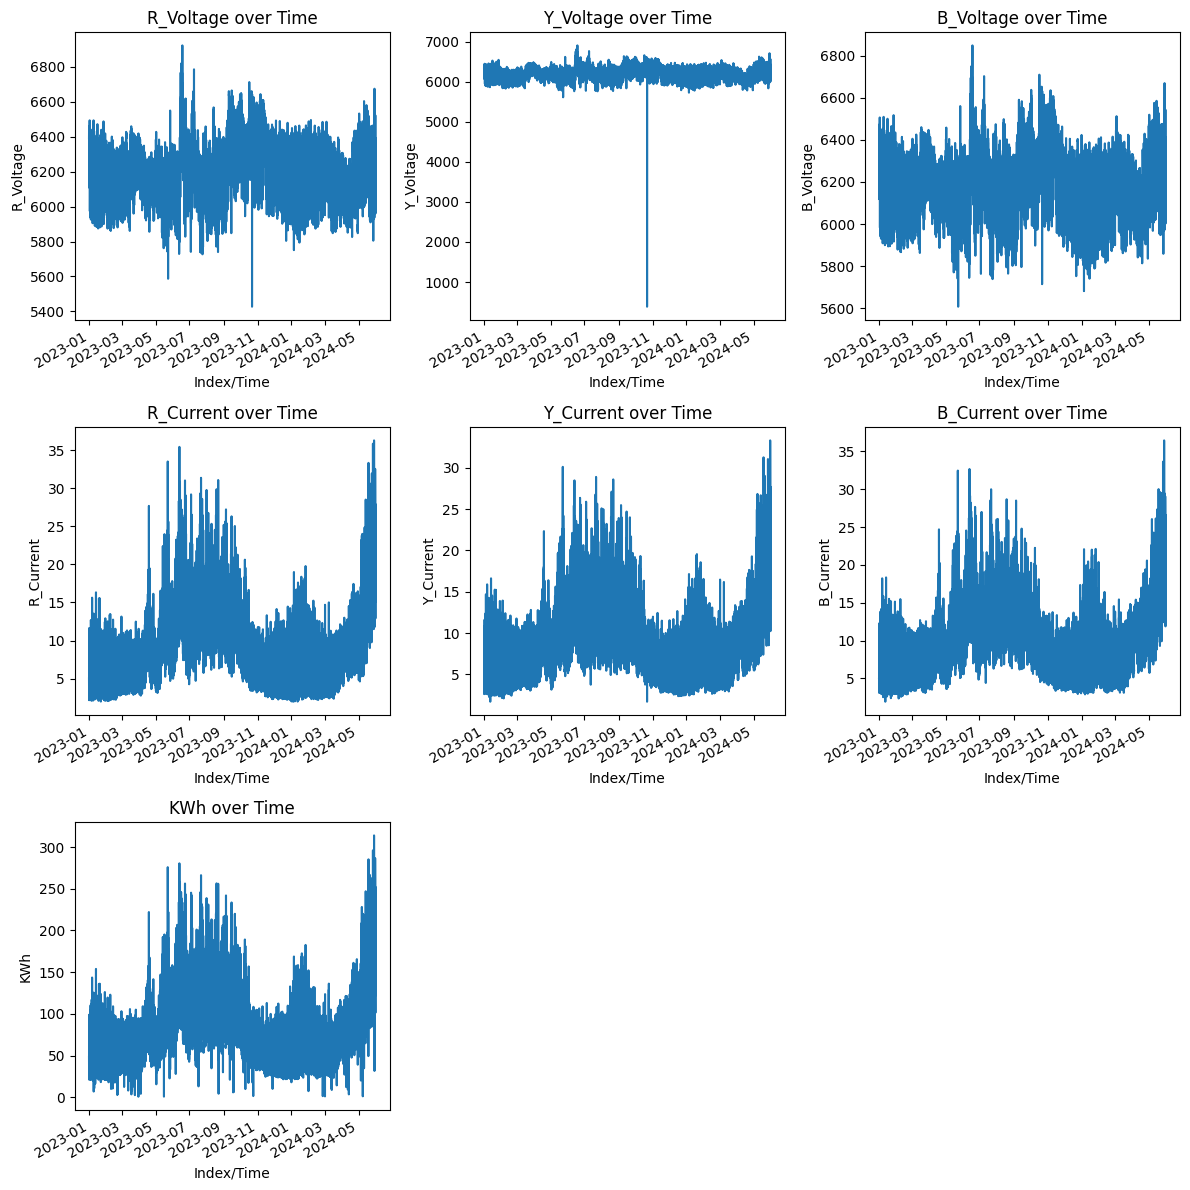

In [101]:
import matplotlib.pyplot as plt

# Define the number of columns for subplots
n_cols = 3  # Adjust this based on how many columns you want per row
n_rows = (len(df.columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each column in the DataFrame
for i, col in enumerate(df.columns):
    df[col].plot(ax=axes[i])  # Plot on the corresponding subplot
    axes[i].set_title(f"{col} over Time")  # Set the title for each subplot
    axes[i].set_ylabel(col)  # Set the y-label for each subplot
    axes[i].set_xlabel("Index/Time")  # Set the x-label for each subplot

# Remove any empty subplots (if there are fewer columns than subplots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()  # Show the plot


In [102]:
df.columns

Index(['R_Voltage', 'Y_Voltage', 'B_Voltage', 'R_Current', 'Y_Current',
       'B_Current', 'KWh'],
      dtype='object')

In [103]:

df.loc[(df['R_Voltage']<5000 )| (df['Y_Voltage']<5000 )|(df['B_Voltage']<5000 )]

,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
creation_time,,,,,,,
2023-10-21 23:00:00,5591.0,383.0,5715.0,5.34,1.70,7.41,34.7
2023-10-21 23:30:00,5427.0,547.0,5926.0,5.14,1.86,7.37,28.5


In [104]:

df.loc[(df['R_Current']<1 )| (df['Y_Current']<1 )|(df['B_Current']<1 )]

,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
creation_time,,,,,,,


In [105]:
df[['KWh']].describe()

,KWh
count,24777.000000
mean,81.742374
std,44.207736
min,0.700000
25%,47.700000
50%,71.700000
75%,104.200000
max,314.000000


In [106]:
print((119-51)+(2*119))
print((119-51)-(1.5*51))


306
-8.5


In [107]:
df.loc[df['KWh']>306]

,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
creation_time,,,,,,,
2024-05-29,6193.0,6226.0,6217.0,36.28,30.07,36.46,314.0


null vlaues after resampling: 39
null values after filling: 0


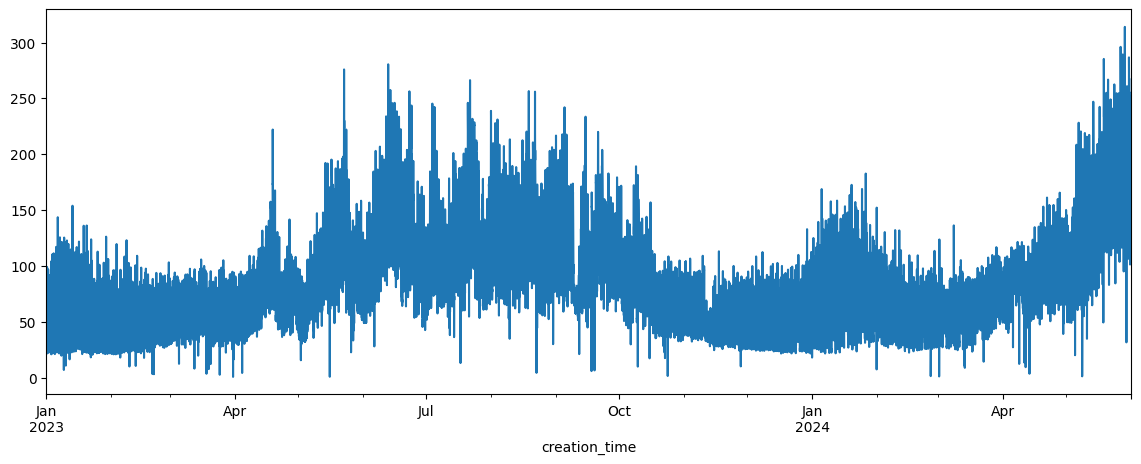

,KWh
creation_time,
2023-01-01 00:00:00,48.3
2023-01-01 00:30:00,42.7
2023-01-01 01:00:00,40.4
2023-01-01 01:30:00,29.6
2023-01-01 02:00:00,32.1
...,...
2024-05-31 21:30:00,228.3
2024-05-31 22:00:00,235.3
2024-05-31 22:30:00,252.0


In [112]:
resample_df = df[['KWh']].resample(rule="30min").asfreq()
print(f"null vlaues after resampling: {resample_df.isna().sum().sum()}")
# resample_df[resample_df.isna().any(axis=1)]
resample_df = resample_df.interpolate(method="linear")
print(f"null values after filling: {resample_df.isna().sum().sum()}")
resample_df['KWh'].plot()
plt.show()
resample_df

## feature engineering

In [125]:
def holidays_list(start_date, end_date):
    holiday_list = []
    india_holidays = holidays.CountryHoliday('India', years=start_date.year)
    # Iterate through each date from start_date to end_date
    current_date = start_date
    while current_date <= end_date:
        # Check if the current date is a holiday in India or a Sunday
        if current_date in india_holidays or current_date.weekday() == 6:
            holiday_list.append(current_date)
        current_date += timedelta(days=1)

    return holiday_list


def weather_data_api(latitude, longitude, from_date, to_date, duration="hour"):
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={from_date}&end_date={to_date}&hourly=temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,wind_speed_10m,wind_speed_100m"
    response = requests.get(url)
    response.raise_for_status()
    weather_data = response.json()

    # for i in range(len(weather_data['hourly']['time'])):
    #                 hour_data = {
    #     # "_id": f"{site_data['_id']}_{weather_data['hourly']['time'][i]}",  # MongoDB's unique identifier
    #     # "site_id": site_data["_id"],
    #     "time": weather_data['hourly']['time'][i],
    #     "temperature_2m": weather_data['hourly'].get('temperature_2m', [])[i],
    #     "relative_humidity_2m": weather_data['hourly'].get('relative_humidity_2m', [])[i],
    #     "apparent_temperature": weather_data['hourly'].get('apparent_temperature', [])[i],
    #     "precipitation": weather_data['hourly'].get('precipitation', [])[i],
    #     "wind_speed_10m": weather_data['hourly'].get('wind_speed_10m', [])[i],
    #     "wind_speed_100m": weather_data['hourly'].get('wind_speed_100m', [])[i],
    #     "creation_time_iso": datetime.utcfromtimestamp(
    #         datetime.strptime(weather_data['hourly']['time'][i],
    #                             '%Y-%m-%dT%H:%M').timestamp()).isoformat()
    # }
    # weather_df = pd.DataFrame(weather_data['hourly'])
    weather_df = pd.DataFrame({
                            'time': weather_data['hourly']['time'],
                            'apparent_temperature': weather_data['hourly']['apparent_temperature'],
                            'rain': weather_data['hourly']['rain'],
                            'wind_speed_10m': weather_data['hourly']['wind_speed_10m'],
                            "relative_humidity_2m": weather_data['hourly']['relative_humidity_2m']

                        })
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    weather_df.rename(columns={"time":"creation_time"}, inplace=True)
    weather_df.set_index("creation_time",inplace=True,drop=True)

    if duration != "hour":
        resampled_df = weather_df.resample(rule=duration)
        resampled_df = resampled_df.interpolate(method="linear")  # Linear interpolation

        resampled_df.reset_index(inplace=True)
        return resampled_df
    return weather_df


def correlation_matrix(df):
    correlation_matrix_data = df.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(18, 10))
    # Draw the heatmap
    sns.heatmap(correlation_matrix_data, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
    # Show the plot
    plt.show()

def add_lags(dff, target_col, large_data= False):
    # target_map = dff['consumed_unit'].to_dict()
    target_map = dff[target_col].to_dict()

    # 1 Hour, 2 Hours, 6 Hours
    dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
    dff['lag2_hours']  =  (dff.index - pd.Timedelta('2 hours')).map(target_map)
    dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
    # dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
    # dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
    dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
    # dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
    # dff['lag3_days']   =  (dff.index - pd.Timedelta('3 days')).map(target_map)
    dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)

    # if large_data:
    # dff['lag_15_day'] = (dff.index - pd.Timedelta('15 days')).map(target_map)
    dff['lag_30_day'] = (dff.index - pd.Timedelta('30 days')).map(target_map)
    # dff['lag_45_day'] = (dff.index - pd.Timedelta('45 days')).map(target_map)
        # logger.info(f" lags added for large data")
    #     return dff
    # else:
    


    # logger.info(f"lags added")
    return dff



def create_features(hourly_data,lagre_data= False):

    hourly_data = hourly_data.copy()
    # Check if the index is in datetime format
    if not isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data.index = pd.to_datetime(hourly_data.index)
    
    hourly_data['hour'] = hourly_data.index.hour
    hourly_data['day'] = hourly_data.index.day
    hourly_data['dayofweek'] = hourly_data.index.dayofweek
    hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['dayofyear'] = hourly_data.index.dayofyear
    # hourly_data['is_weekend'] = hourly_data['dayofweek'].isin([5, 6]).astype(int)
    hourly_data['holiday'] = 0
    # if lagre_data:
    # hourly_data['month'] = hourly_data.index.month
    # hourly_data['quarter'] = hourly_data.index.quarter
    # hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['year'] = hourly_data.index.year

    return hourly_data

from_date:  2023-01-01 to_date:  2024-05-31
holidays_lst: [datetime.date(2023, 1, 1), datetime.date(2023, 1, 8), datetime.date(2023, 1, 14), datetime.date(2023, 1, 15), datetime.date(2023, 1, 22), datetime.date(2023, 1, 26), datetime.date(2023, 1, 29), datetime.date(2023, 2, 5), datetime.date(2023, 2, 12), datetime.date(2023, 2, 19), datetime.date(2023, 2, 26), datetime.date(2023, 3, 5), datetime.date(2023, 3, 8), datetime.date(2023, 3, 12), datetime.date(2023, 3, 19), datetime.date(2023, 3, 26), datetime.date(2023, 4, 2), datetime.date(2023, 4, 7), datetime.date(2023, 4, 9), datetime.date(2023, 4, 16), datetime.date(2023, 4, 21), datetime.date(2023, 4, 22), datetime.date(2023, 4, 23), datetime.date(2023, 4, 30), datetime.date(2023, 5, 1), datetime.date(2023, 5, 7), datetime.date(2023, 5, 14), datetime.date(2023, 5, 21), datetime.date(2023, 5, 28), datetime.date(2023, 6, 4), datetime.date(2023, 6, 11), datetime.date(2023, 6, 18), datetime.date(2023, 6, 25), datetime.date(2023, 6, 28), 

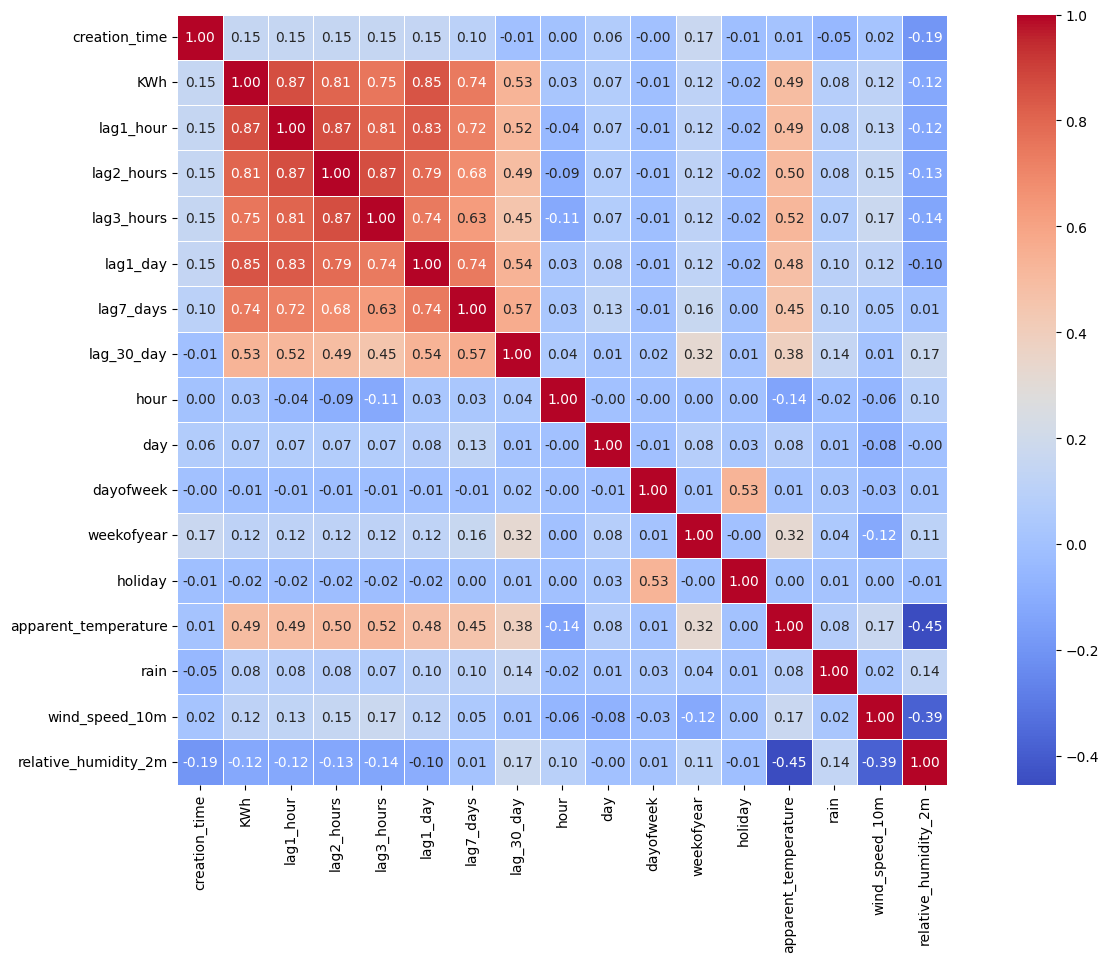

,creation_time,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
0,2023-01-01 00:00:00,48.3,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,52,1,5.7,0.0,6.4,97
1,2023-01-01 00:30:00,42.7,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,52,1,5.7,0.0,6.4,97
2,2023-01-01 01:00:00,40.4,48.3,NaN,NaN,NaN,NaN,NaN,1,1,6,52,1,4.8,0.0,8.0,98
3,2023-01-01 01:30:00,29.6,42.7,NaN,NaN,NaN,NaN,NaN,1,1,6,52,1,4.8,0.0,8.0,98
4,2023-01-01 02:00:00,32.1,40.4,48.3,NaN,NaN,NaN,NaN,2,1,6,52,1,6.2,0.0,6.0,97


In [140]:

latitude, longitude = "28.46072","77.537381" #"28.625361","77.376214"#, 28.628059,77.378912
from_date = resample_df.first_valid_index().date()
to_date = resample_df.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
weather_df = weather_data_api(latitude,longitude,from_date,to_date,duration="30min")

holidays_lst= holidays_list(from_date,to_date)
print("holidays_lst:",holidays_lst)
df_lags = add_lags(resample_df,target_col="KWh")
df_features = create_features(df_lags)


for date in holidays_lst:
    df_features.loc[f"{date}", 'holiday'] = 1
final_df = df_features.merge(weather_df,on=["creation_time"])
# final_df.drop(['creation_time'],axis=1,inplace=True)
# final_df.fillna(0,inplace= True)
# final_df.dropna(inplace=True)
correlation_matrix(final_df)
final_df.head()

In [146]:
weather_df

,creation_time,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
0,2023-01-01 00:00:00,5.7,0.0,6.4,97
1,2023-01-01 00:30:00,5.7,0.0,6.4,97
2,2023-01-01 01:00:00,4.8,0.0,8.0,98
3,2023-01-01 01:30:00,4.8,0.0,8.0,98
4,2023-01-01 02:00:00,6.2,0.0,6.0,97
...,...,...,...,...,...
24810,2024-05-31 21:00:00,28.5,0.0,8.3,16
24811,2024-05-31 21:30:00,28.5,0.0,8.3,16
24812,2024-05-31 22:00:00,28.4,0.0,8.2,15
24813,2024-05-31 22:30:00,28.4,0.0,8.2,15


In [142]:
final_df.isna().sum()
final_df.dropna(inplace=True)
final_df.reset_index(drop=True, inplace=True)
final_df.set_index("creation_time",inplace=True)
# final_df.drop(['creation_time'],axis=1,inplace=True)
final_df

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,
2023-01-31 00:00:00,46.8,61.1,62.5,58.6,48.4,38.5,48.3,0,31,1,5,0,9.8,0.0,9.1,96
2023-01-31 00:30:00,46.9,55.8,69.1,56.2,36.7,36.7,42.7,0,31,1,5,0,9.8,0.0,9.1,96
2023-01-31 01:00:00,32.4,46.8,61.1,62.5,32.3,28.9,40.4,1,31,1,5,0,9.9,0.0,9.3,95
2023-01-31 01:30:00,26.4,46.9,55.8,69.1,42.2,26.2,29.6,1,31,1,5,0,9.9,0.0,9.3,95
2023-01-31 02:00:00,21.8,32.4,46.8,61.1,38.8,24.1,32.1,2,31,1,5,0,9.8,0.0,10.9,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 21:00:00,199.8,154.3,156.1,163.6,164.1,170.0,136.0,21,31,4,22,0,28.5,0.0,8.3,16
2024-05-31 21:30:00,228.3,157.5,137.4,180.0,177.6,180.8,96.5,21,31,4,22,0,28.5,0.0,8.3,16
2024-05-31 22:00:00,235.3,199.8,154.3,156.1,200.4,186.0,100.7,22,31,4,22,0,28.4,0.0,8.2,15


In [148]:
train_dataset = final_df.loc[~((final_df.index.month==5)& (final_df.index.year == 2024))]
train_dataset

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,
2023-01-31 00:00:00,46.8,61.1,62.5,58.6,48.4,38.5,48.3,0,31,1,5,0,9.8,0.0,9.1,96
2023-01-31 00:30:00,46.9,55.8,69.1,56.2,36.7,36.7,42.7,0,31,1,5,0,9.8,0.0,9.1,96
2023-01-31 01:00:00,32.4,46.8,61.1,62.5,32.3,28.9,40.4,1,31,1,5,0,9.9,0.0,9.3,95
2023-01-31 01:30:00,26.4,46.9,55.8,69.1,42.2,26.2,29.6,1,31,1,5,0,9.9,0.0,9.3,95
2023-01-31 02:00:00,21.8,32.4,46.8,61.1,38.8,24.1,32.1,2,31,1,5,0,9.8,0.0,10.9,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 21:30:00,118.5,135.4,101.1,77.8,102.4,101.2,68.0,21,30,1,18,0,19.0,0.0,12.0,24
2024-04-30 22:00:00,131.0,127.5,134.5,70.5,105.5,74.2,74.7,22,30,1,18,0,19.1,0.0,9.7,23
2024-04-30 22:30:00,122.0,118.5,135.4,101.1,110.2,81.6,84.5,22,30,1,18,0,19.1,0.0,9.7,23


In [144]:
test_dataset = final_df.loc[(final_df.index.month==5)& (final_df.index.year == 2024)]
test_dataset

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,
2024-05-01 00:00:00,150.1,142.0,131.0,127.5,127.6,82.5,87.50,0,1,2,18,1,17.6,0.0,13.9,30
2024-05-01 00:30:00,145.7,149.8,122.0,118.5,124.9,87.0,73.30,0,1,2,18,1,17.6,0.0,13.9,30
2024-05-01 01:00:00,141.2,150.1,142.0,131.0,124.0,88.9,72.45,1,1,2,18,1,18.7,0.0,15.9,37
2024-05-01 01:30:00,134.3,145.7,149.8,122.0,131.5,90.7,71.60,1,1,2,18,1,18.7,0.0,15.9,37
2024-05-01 02:00:00,131.5,141.2,150.1,142.0,126.6,91.1,94.60,2,1,2,18,1,20.3,0.0,18.5,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 21:00:00,199.8,154.3,156.1,163.6,164.1,170.0,136.00,21,31,4,22,0,28.5,0.0,8.3,16
2024-05-31 21:30:00,228.3,157.5,137.4,180.0,177.6,180.8,96.50,21,31,4,22,0,28.5,0.0,8.3,16
2024-05-31 22:00:00,235.3,199.8,154.3,156.1,200.4,186.0,100.70,22,31,4,22,0,28.4,0.0,8.2,15


In [145]:
31*48

1488